# MODELLER examples
- Here is an exmaple/tutorial on doing homology modeling with modeller.
- We follow in part this tutorial https://salilab.org/modeller/tutorial/basic.html
- Many useful starting Modeller scripts, may be generated easily by Chimera!

## Some theory
- MODELLER manual is [here](https://salilab.org/modeller/documentation.html)
- Modeller workflow is described in this section https://salilab.org/modeller/9.23/manual/node493.html
- See first an article in wikipedia https://en.wikipedia.org/wiki/Homology_modeling

### Genral info about homology modeling
- Their may be different approaches to homology modeling, e.g. fragment assembly, segment matching, etc.
- Modeller uses the most well known - "Satisfaction of sptial restraints", takes its inspiration from calculations required to construct a three-dimensional structure from data generated by NMR spectroscopy
- Homology modelling has 4 steps:
template selection, target-template alignment, model construction, and model assessment
- The sequence alignment and template structure are used to produce a structural model of the target.
- Regions of the target sequence that are not aligned to a template are modeled by loop modeling; they are the most susceptible to major modeling errors and occur with higher frequency when the target and template have low sequence identity.
- Assessment of homology models without reference to the true target structure is usually performed with two methods: statistical potentials or physics-based energy calculations.
- Examples of popular statistical potentials include Prosa and DOPE.
- A very extensive model validation report can be obtained using the Radboud Universiteit Nijmegen "What Check" software. http://swift.cmbi.ru.nl/gv/whatcheck/ or the web-server version http://swift.cmbi.ru.nl/
- Also see this link for the discussion of PDB structure quality https://swift.cmbi.umcn.nl/gv/whatcheck/
- The two most common and large-scale sources of error in homology modeling are poor template selection and inaccuracies in target-template sequence alignment.
- Serious local errors can arise in homology models where an insertion or deletion mutation or a gap in a solved structure result in a region of target sequence for which there is no corresponding template. This problem can be minimized by the use of multiple templates, but the method is complicated by the templates' differing local structures around the gap and by the likelihood that a missing region in one experimental structure is also missing in other structures of the same protein family. Missing regions are most common in loops where high local flexibility increases the difficulty of resolving the region by structure-determination methods.

### What and how MODELLER does?

#### Automodel class
- This is usually the working horse of modeller.   
- See here for description  https://salilab.org/modeller/9.23/manual/node493.html

```
Input: script file, alignment file, PDB file(s) for template(s).

Output:

job.log	log file
job.ini	initial conformation for optimization
job.rsr	restraints file
job.sch	VTFM schedule file
job.B9999????	PDB atom file(s) for the model(s) of the target sequence
job.V9999????	violation profiles for the model(s)
job.D9999????	progress of optimization
job.BL9999????	optional loop model(s)
job.DL9999????	progress of optimization for loop model(s)
job.IL9999????	initial structures for loop model(s)
```

The main MODELLER routines used in each step are given in parentheses.

1. Read and check the alignment between the target sequence and the template structures 
(alignment.append() and alignment.check()).
2. Calculate restraints on the target from its alignment with the templates:
        2.1. Generate molecular topology for the target sequence (model.generate_topology()). Disulfides in the target are assigned here from the equivalent disulfides in the templates (model.patch_ss_templates()). Any user defined patches are also done here (as defined in the automodel.special_patches() routine).
        2.2 Calculate coordinates for atoms that have equivalent atoms in the templates as an average over all templates (model.transfer_xyz()) (alternatively, read the initial coordinates from a file).
        2.3. Build the remaining unknown coordinates using internal coordinates from the CHARMM topology library (model.build()).
        2.4. Write the initial model to a file with extension .ini (model.write()).
        2.5. Generate stereochemical, homology-derived, and special restraints (Restraints.make()) (alternatively, skip this and assume the restraints file already exists): See details via the link above.
        2.6. Write all restraints to a file with extension .rsr (Restraints.write()).
        
3. Calculate model(s) that satisfy the restraints as well as possible. For each model:
        3.1. Generate the optimization schedule for the variable target function method (VTFM).
        3.2. Read the initial model (usually from the .ini file from 2.d) (model.read()).
        3.3. Randomize the initial structure by adding a random number between  $\pm$automodel.deviation angstroms to all atomic positions (selection.randomize_xyz()).
        3.4. Optimize the model:
        - Partially optimize the model by VTFM; Repeat the following steps as many times as specified by the optimization schedule:
            - Select only the restraints that operate on the atoms that are close enough in sequence, as specified by the current step of VTFM (Restraints.pick()).
            - Optimize the model by conjugate gradients, using only currently selected restraints (conjugate_gradients()).
        - Refine the model by simulated annealing with molecular dynamics, if so selected:
            - Do a short conjugate gradients optimization (conjugate_gradients()).
            - Increase temperature in several steps and do molecular dynamics optimization at each temperature (molecular_dynamics()).
            - Decrease temperature in several steps and do molecular dynamics optimization at each temperature (molecular_dynamics()).
            - Do a short conjugate gradients optimization (conjugate_gradients()).
5. Calculate the remaining restraint violations and write them out (selection.energy()).
6. Write out the final model to a file with extension .B9999????.pdb where ???? indicates the model number (model.write()). Also write out the violations profile.
7. Superpose the models and the templates, if so selected by automodel.final_malign3d = True, and write them out (alignment.append_model(), alignment.malign3d()).
8. Do loop modeling if so selected using the loopmodel class.

#### Loopmodel class
- Triggers the automodel and then additionaly optimizes loops.

- The loop modeling method first takes the generated model, and selects all standard residues around gaps in the alignment for additional loop modeling. (To select a different region for modeling, simply redefine the loopmodel.select loop atoms() routine to select the relevant atoms.) An initial loop conformation is then generated by simply positioning the atoms of the loop with uniform spacing on the line that connects the main- chain carbonyl oxygen and amide nitrogen atoms of the N- and C-terminal anchor regions respectively (to change this, override the loopmodel.build ini loop() method), and this model is written out to a file with the .IL extension.
- Next, a number of loop models are generated from loopmodel.loop.starting model to loopmodel.loop.ending model. Each takes the initial loop conformation and randomizes it by ±5 ̊A in each of the Cartesian directions. The model is then optimized thoroughly twice, firstly considering only the loop atoms and secondly with these atoms “feeling” the rest of the system. The loop optimization relies on an atomistic distance-dependent statistical potential of mean force for nonbond interactions [Melo & Feytmans, 1997]. This classifies all amino acid atoms into one of 40 atom classes (as defined in LIB/atmcls-melo.lib) and applies a potential as Modeller cubic spline restraints (as defined in LIB/melo-dist1.lib). No homology-derived restraints are used during this procedure. Each loop model is written out with the .BL extension.
- For more information, please consult the loop modeling paper [Fiser et al., 2000] or look at the loop modeling class itself in modlib/modeller/automodel/loopmodel.py.

### Other notes

 It is good to have at least 35-40% sequence identity to build a model. Sometimes even 30% is OK.

The best way to prevent knots is to start with a starting structure that is as close to the desired final model as possible. Other than that, the only solution at this point is to calculate independently many models and hope that in some runs there won't be knots. Knots usually occur when one or more neighboring long insertions (i.e., longer than 15 residues) are modeled from scratch. The reason is that an insertion is built from a randomized distorted structure that is located approximately between the two anchoring regions. Under such conditions, it is easy for the optimizer to “fall” into a knot and then not be able to recover from it. Sometimes knots result from an incorrect alignment, especially when more than one template is used. When the alignment is correct, knots are a result of optimization not being good enough. However, making optimization more thorough by increasing the CPU time would not be worth it on the average as knots occur relatively infrequently. The excluded volume restraints are already included in standard comparative modeling with the automodel class

# Example 1: build a model from one structure with one chain
 - We have chicken histone H1 globular domain structure, PDB id 1HST
 - We want to build a human model, using UniProtID P07305

## Step 1. Examining the template PDB and its sequence

In [17]:
# Let's get template 3D structure from PDB
import pypdb
with open('1HST.pdb','w') as f:
    f.write(pypdb.get_pdb_file('1HST', filetype='pdb', compression=False))

In [81]:
#Let's look at it #NB only chain A is displayed from a dimer
import nglview as nv
nv.show_structure_file('1HST.pdb')

NGLWidget()

## Let's obtain protein sequence in diffrent ways

#### Way 1: from pdb structure
- This will be the true template sequence
- NB: if there are gaps in pdb structure the PPBuilder will build several peptides!

In [119]:
#Let's get a template sequence
from Bio.PDB import *
#See docs here https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ
p = PDBParser()
structure = p.get_structure('H1', '1HST.pdb')
ppb = PPBuilder()
seqs=[]
for pp in ppb.build_peptides(structure):
    seqs.append(pp.get_sequence())
pdb_template_seq=seqs[0]
# Let's view structure
#nv.show_biopython(structure)

In [120]:
pdb_template_seq

Seq('SHPTYSEMIAAAIRAEKSRGGSSRQSIQKYIKSHYKVGHNADLQIKLSIRRLLA...LAK', ProteinAlphabet())

#### Way 2: from SEQREC reord in pdb-file
- SEQREC often contains portions of the protein that were not resolved in 3D strcture.
- See https://pdb101.rcsb.org/learn/guide-to-understanding-pdb-data/primary-sequences-and-the-pdb-format
- We can get it from PDB fasta or indirectly from genbank together with annotation.

In [121]:
#Let's use pytexshade to look at the sequence
from Bio import Entrez
Entrez.email = "alex@intbio.org"  # Always tell NCBI who you are
handle = Entrez.efetch(db="protein", id="1HST_A", rettype="gb", retmode="text")
pdb_SEQREC_record = SeqIO.read(handle, "genbank")
pdb_SEQREC_seq=pdb_SEQREC_record.seq

In [122]:
print(pdb_SEQREC_seq)

SRRSASHPTYSEMIAAAIRAEKSRGGSSRQSIQKYIKSHYKVGHNADLQIKLSIRRLLAAGVLKQTKGVGASGSFRLAKSDKAKRSPGKK


#### Way 3: from UNIPROT referenced in PDB
- NB: this might not actually be the exact same sequence, some variation and mutation are possible.
- But at least it will be full length!
- 1HST lists UNIPROT id P02259

In [123]:
#Let's get target seqeunce
from Bio import SeqIO
import urllib.request

handle = urllib.request.urlopen("http://www.uniprot.org/uniprot/P02259.xml")

pdb_uniprot_record = SeqIO.read(handle, "uniprot-xml")
pdb_uniprot_seq=pdb_uniprot_record.seq


In [124]:
print(pdb_uniprot_seq)

MTESLVLSPAPAKPKRVKASRRSASHPTYSEMIAAAIRAEKSRGGSSRQSIQKYIKSHYKVGHNADLQIKLSIRRLLAAGVLKQTKGVGASGSFRLAKSDKAKRSPGKKKKAVRRSTSPKKAARPRKARSPAKKPKATARKARKKSRASPKKAKKPKTVKAKSRKASKAKKVKRSKPRAKSGARKSPKKK


### Let's plot an alignment from these sequences and examine them
- We will use annotation as provided in genbank
- We will use Muscle program to do multiple sequnce alignment (`muscle` command should be accessible and installed).

In [125]:
#Step 1. Prepare records
records=[SeqRecord(id='pdb_template_seq',seq=pdb_template_seq),SeqRecord(id='pdb_SEQREC_seq',seq=pdb_SEQREC_seq),SeqRecord(id='pdb_uniprot_seq',seq=pdb_uniprot_seq)]
#Step 2. Make an alignment using Muscle
from Bio.Align.Applications import MuscleCommandline
SeqIO.write(records,'temp.fasta','fasta')
muscle_cline = MuscleCommandline(input="temp.fasta")
stdout, stderr = muscle_cline()
from Bio import AlignIO
from io import StringIO
align = AlignIO.read(StringIO(stdout), "fasta")

In [126]:
print(align)

SingleLetterAlphabet() alignment with 3 rows and 190 columns
------------------------SHPTYSEMIAAAIRAEKSRG...--- pdb_template_seq
-------------------SRRSASHPTYSEMIAAAIRAEKSRG...--- pdb_SEQREC_seq
MTESLVLSPAPAKPKRVKASRRSASHPTYSEMIAAAIRAEKSRG...KKK pdb_uniprot_seq


In [127]:
align[1].features=pdb_SEQREC_record.features

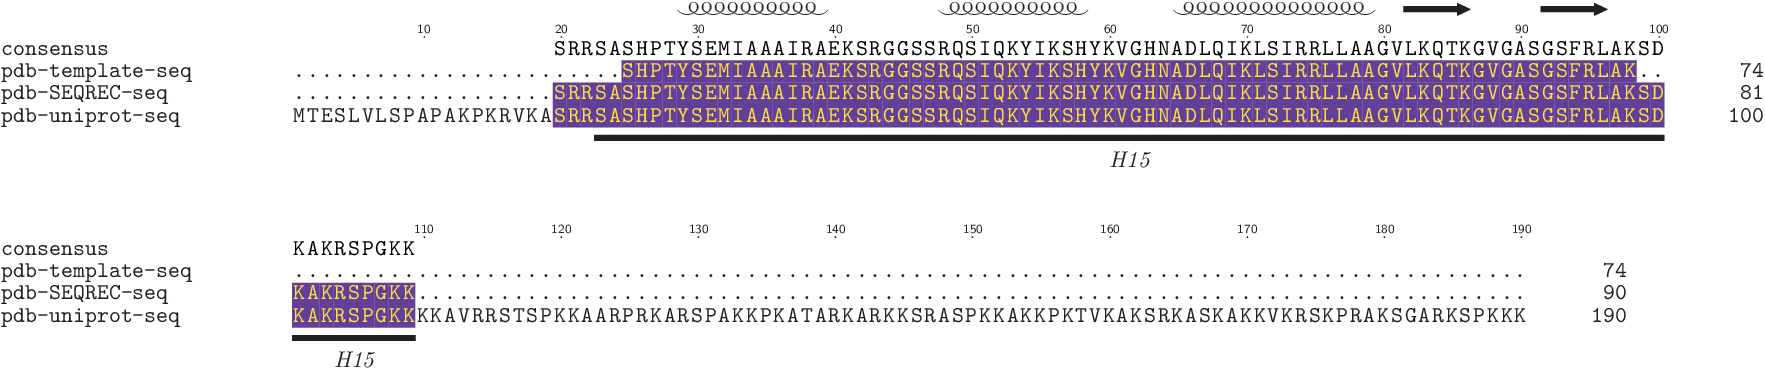

In [128]:
from pytexshade.shade import seqfeat2shadefeat
from pytexshade import ipyshade
ipyshade.shadedmsa(align,\
     shading_modes=['similar'],# list of shading modes according to TexShade, supported are "similar", "hydropathy_functional", "chemical_functional", "structure_functional", "charge_functional", "diverse"\
     legend=False,features=seqfeat2shadefeat(align),title='',\
     logo=False, #SeqLogo \
     hideseqs=False,#activate \hidseqs command \ 
     splitN=20, #alignment will be split into splitN batches\
     setends=[1,10000], # a section of alignment will be displayed between setends[0] and setends[1]\
     ruler=True, # Add a ruler\
     show_seq_names=True,# Show sequence names\
     funcgroups=None, # Hilight functional groups, Tex code should be inserted example funcgroups="\\funcgroup{xxx}{CT}{White}{Green}{upper}{up} \\funcgroup{yyy}{GA}{White}{Blue}{upper}{up}" \
     show_seq_length=True, #Show sequence length \
     resperline=100, startnumber=1, debug = False
    )

## Step 2. Selecting and examining the target sequence
- We will select some interesting sequences from the H1 family.
- We'll do a balst search against RefSeq database, and then select.

In [ ]:
msau=MultipleSeqAlignment([record])
msau[0].id='H1_SEQRECORD'
seqrec=msau[0].seq

In [57]:
#Let's use pytexshade to look at the sequence
from Bio import Entrez
from Bio.Align import MultipleSeqAlignment
Entrez.email = "alex@intbio.org"  # Always tell NCBI who you are
handle = Entrez.efetch(db="protein", id="1HST_A", rettype="gb", retmode="text")
record = SeqIO.read(handle, "genbank")
msau=MultipleSeqAlignment([record])
msau[0].id='H1_SEQRECORD'
seqrec=msau[0].seq

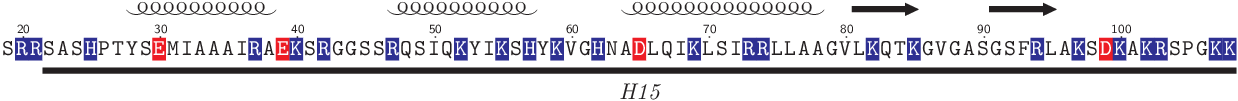

In [58]:
from pytexshade.shade import seqfeat2shadefeat
from pytexshade import ipyshade
ipyshade.shadedmsa(msau,\
     shading_modes=['charge_functional'],# list of shading modes according to TexShade, supported are "similar", "hydropathy_functional", "chemical_functional", "structure_functional", "charge_functional", "diverse"\
     legend=False,features=seqfeat2shadefeat(msau),title='',\
     logo=False, #SeqLogo \
     hideseqs=False,#activate \hidseqs command \ 
     splitN=20, #alignment will be split into splitN batches\
     setends=[1,10000], # a section of alignment will be displayed between setends[0] and setends[1]\
     ruler=True, # Add a ruler\
     show_seq_names=False,# Show sequence names\
     funcgroups=None, # Hilight functional groups, Tex code should be inserted example funcgroups="\\funcgroup{xxx}{CT}{White}{Green}{upper}{up} \\funcgroup{yyy}{GA}{White}{Blue}{upper}{up}" \
     show_seq_length=False, #Show sequence length \
     resperline=100, startnumber=19, debug = False
    )

In [44]:
#Let's get a template sequence
from Bio.PDB import *
#See docs here https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ
p = PDBParser()
structure = p.get_structure('H1', '1HST.pdb')
ppb = PPBuilder()
seqs=[]
for pp in ppb.build_peptides(structure):
    seqs.append(pp.get_sequence())
pdb_seq=seqs[0]
# Let's view structure
#nv.show_biopython(structure)

In [46]:
#Let's get target seqeunce
from Bio import SeqIO
import urllib.request

handle = urllib.request.urlopen("http://www.uniprot.org/uniprot/P07305.xml")

record = SeqIO.read(handle, "uniprot-xml")
uniprot_seq=record.seq
#print(record)
print(record.name)
print(record.seq)

H10_HUMAN
MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVGENADSQIKLSIKRLVTTGVLKQTKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKAASKAPTKKPKATPVKKAKKKLAATPKKAKKPKTVKAKPVKASKPKKAKPVKPKAKSSAKRAGKKK


In [51]:
#Let's align seqrec to uniprot
from Bio import pairwise2
alignments = pairwise2.align.globalxs(seqrec,uniprot_seq,-10,-1,penalize_end_gaps=False)

seqrec_uniprot_aln=alignments[0]
print(seqrec_uniprot_aln)


('------------------SRRSASHPTYSEMIAAAIRAEKSRGGSSRQSIQKYIKSHYKVGHNADLQIKLSIRRLLAAGVLKQTKGVGASGSFRLAKSDKAKRSPGKK--------------------------------------------------------------------------------------', 'MTENSTSAPAAKPKRAKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVGENADSQIKLSIKRLVTTGVLKQTKGVGASGSFRLAKSDEPKKSVAFKKTKKEIKKVATPKKASKPKKAASKAPTKKPKATPVKKAKKKLAATPKKAKKPKTVKAKPVKASKPKKAKPVKPKAKSSAKRAGKKK', 68.0, 0, 194)


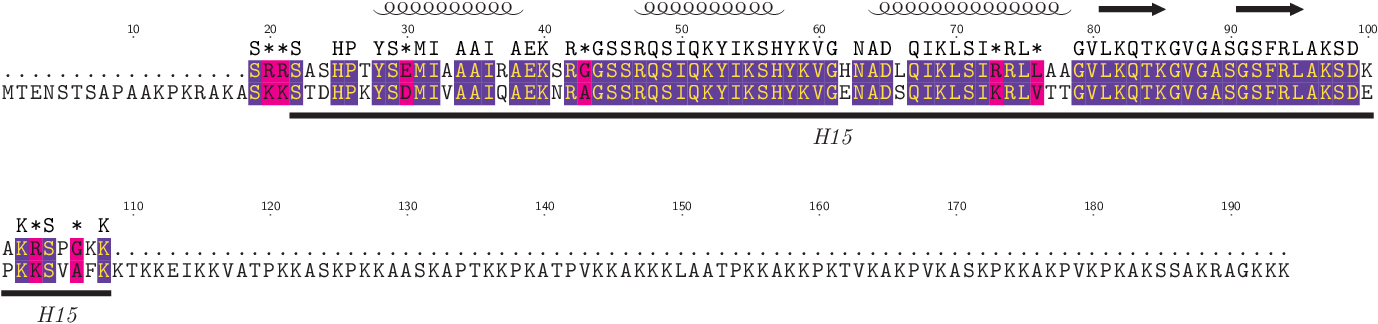

In [80]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
msa=MultipleSeqAlignment([SeqRecord(id='%s'%(n),seq=Seq(seqrec_uniprot_aln[i])) for i,n in zip([0,1],['SEQREC','UNIPROT'])])
ipyshade.shadedmsa(msa,\
     shading_modes=['similar'],# list of shading modes according to TexShade, supported are "similar", "hydropathy_functional", "chemical_functional", "structure_functional", "charge_functional", "diverse"\
     legend=False,features=seqfeat2shadefeat(msau,seqref='SEQREC'),title='',\
     logo=False, #SeqLogo \
     hideseqs=False,#activate \hidseqs command \ 
     splitN=20, #alignment will be split into splitN batches\
     setends=[1,10000], # a section of alignment will be displayed between setends[0] and setends[1]\
     ruler=True, # Add a ruler\
     show_seq_names=False,# Show sequence names\
     funcgroups=None, # Hilight functional groups, Tex code should be inserted example funcgroups="\\funcgroup{xxx}{CT}{White}{Green}{upper}{up} \\funcgroup{yyy}{GA}{White}{Blue}{upper}{up}" \
     show_seq_length=False, #Show sequence length \
     resperline=100, startnumber=1, debug = False
    )

### Let's trim sequence a bit, to remove long tails

In [64]:
print(msa[:,15:110])

Alphabet() alignment with 2 rows and 95 columns
---SRRSASHPTYSEMIAAAIRAEKSRGGSSRQSIQKYIKSHYK...K-- SEQREC
AKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYK...KKT UNIPROT


In [70]:
model_seq_rec=msa[:,15:110][1]

In [74]:
#important to set protein alphabet to sequence, so that PIR format will be correct
from Bio.Alphabet import IUPAC
model_seq_rec.seq.alphabet=IUPAC.protein

In [75]:
model_seq_rec

SeqRecord(seq=Seq('AKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVGENADSQIK...KKT', IUPACProtein()), id='humanH1', name='sequence:humanH1::::::::', description='', dbxrefs=[])

### Now we need to prepare input for Modeller

A tricky thing about MODELLER is the preparation of sequences and/or alignment files in PIR-like-format with additional information.
Here is an example
```
>P1;TvLDH
sequence:TvLDH:::::::0.00: 0.00
MSEAAHVLITGAAGQIGYILSHWIASGELYGDRQVYLHLLDIPPAMNRLTALTMELEDCAFPHLAGFVATTDPKA
AFKDIDCAFLVASMPLKPGQVRADLISSNSVIFKNTGEYLSKWAKPSVKVLVIGNPDNTNCEIAMLHAKNLKPEN
FSSLSMLDQNRAYYEVASKLGVDVKDVHDIIVWGNHGESMVADLTQATFTKEGKTQKVVDVLDHDYVFDTFFKKI
GHRAWDILEHRGFTSAASPTKAAIQHMKAWLFGTAPGEVLSMGIPVPEGNPYGIKPGVVFSFPCNVDKEGKIHVV
EGFKVNDWLREKLDFTEKDLFHEKEIALNHLAQGG*
```
The first line contains the sequence code, in the format ">P1;code". The second line with ten fields separated by colons generally contains information about the structure file, if applicable. Only two of these fields are used for sequences, "sequence" (indicating that the file contains a sequence without known structure) and "TvLDH" (the model file name). The rest of the file contains the sequence of TvLDH, with "*" marking its end. The standard one-letter amino acid codes are used. (Note that they must be upper case; some lower case letters are used for non-standard residues. See the file modlib/restyp.lib in the Modeller distribution for more information.)

- Here is decription https://salilab.org/modeller/manual/node496.html#alignmentformat

In [76]:
model_seq_rec.name='sequence:humanH1::::::::'
model_seq_rec.description=''
model_seq_rec.id='humanH1'

In [77]:
handle = open('humanH1.ali', "w")
writer = SeqIO.PirIO.PirWriter(handle)
writer.write_file([model_seq_rec])
handle.close()
!cat humanH1.ali

>P1;humanH1
sequence:humanH1::::::::
AKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVGENADSQIKLSIKRL
VTTGVLKQTKGVGASGSFRLAKSDEPKKSVAFKKT*


In [78]:
#Now we'll do alignment using Modeller
from modeller import *

env = environ()
aln = alignment(env)
mdl = model(env, file='1HST', model_segment=('FIRST:A','LAST:A'))
aln.append_model(mdl, align_codes='1HST_A', atom_files='1HST.pdb')
aln.append(file='humanH1.ali', align_codes='humanH1')
aln.align2d()
aln.write(file='humanH1-1HST_A.ali', alignment_format='PIR')
aln.write(file='humanH1-1HST_A.pap', alignment_format='PAP')


mkapsa__637W> No residue topology library is in memory.
              Better radii would be used if topology.read() is called first.
iup2crm_280W> No topology library in memory or assigning a BLK residue.
              Default CHARMM atom type assigned:  N -->  N
              This message is written only for the first such atom.

Pairwise dynamic programming alignment (ALIGN2D):
  Residue-residue metric   : $(LIB)/as1.sim.mat
  Diagonal                 :          100
  Overhang                 :            0
  Maximal gap length       :       999999
  Local alignment          :            F
  MATRIX_OFFSET (local aln):       0.0000
  FIX_OFFSETS              :      0.0    -1.0    -2.0    -3.0    -4.0
  N_SUBOPT                 :            0
  SUBOPT_OFFSET            :       0.0000
  Alignment block          :            1
  Gap introduction penalty :    -100.0000
  Gap extension penalty    :       0.0000
  Gap diagonal penalty     :       0.0000
  Structure gap penalties  :    3.500

In [79]:
!cat humanH1-1HST_A.ali


>P1;1HST_A
structureX:1HST.pdb:  24 :A:+74  :A:MOL_ID  1; MOLECULE  HISTONE H5; CHAIN  A, B; ENGINEERED  YES:MOL_ID  1; ORGANISM_SCIENTIFIC  GALLUS GALLUS; ORGANISM_COMMON  CHICKEN; ORGANISM_TAXID  9031; CELL_LINE  H5: 2.60: 0.27
---S-----HPTYSEMIAAAIRAEKSRGGSSRQSIQKYIKSHYKVGHNADLQIKLSIRRLLAAGVLKQTKGVGAS
GSFRLAK-------------*

>P1;humanH1
sequence:humanH1:     : :     : :::-1.00:-1.00
AKASKKSTDHPKYSDMIVAAIQAEKNRAGSSRQSIQKYIKSHYKVGENADSQIKLSIKRLVTTGVLKQTKGVGAS
GSFRLAKSDEPKKSVAFKKT*


In [24]:
#Let's run MODELLER
from modeller import *
from modeller.automodel import *
automodel.final_malign3d=True #This will fit model to template
env = environ()
a = automodel(env, alnfile='humanH1-1HST_A.ali',
              knowns=('1HST_A'), sequence='humanH1',
              assess_methods=(assess.DOPE,assess.GA341))
a.starting_model = 1
a.ending_model = 1 #generate one model.
a.make()


check_ali___> Checking the sequence-structure alignment. 

Implied intrachain target CA(i)-CA(i+1) distances longer than  8.0 angstroms:

ALN_POS  TMPL  RID1  RID2  NAM1  NAM2     DIST
----------------------------------------------
END OF TABLE
read_to_681_> topology.submodel read from topology file:        3
mdtrsr__446W> A potential that relies on one protein is used, yet you have at
              least one known structure available. MDT, not library, potential is used.
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies
condens_443_> Restraints marked for deletion were removed.
              Total number of restraints before, now:    10799     9324
>> Model assessment by DOPE potential
iatmcls_286W> MODEL atom not classified:  LYS:OXT  LYS


>> ENERGY; Differences between the model's features and restraints:
Number of all residues in 

### Let's examine files

In [26]:
import nglview as nv
!cp humanH1.ini humanH1_ini.pdb
import MDAnalysis as mda
v=mda.Universe('humanH1_ini.pdb',['humanH1_ini.pdb','humanH1.B99990001_fit.pdb'])
nv.show_mdanalysis(v.select_atoms('all'))
# nv.show_structure_file('humanH1_ini.pdb')

NGLWidget(max_frame=1)

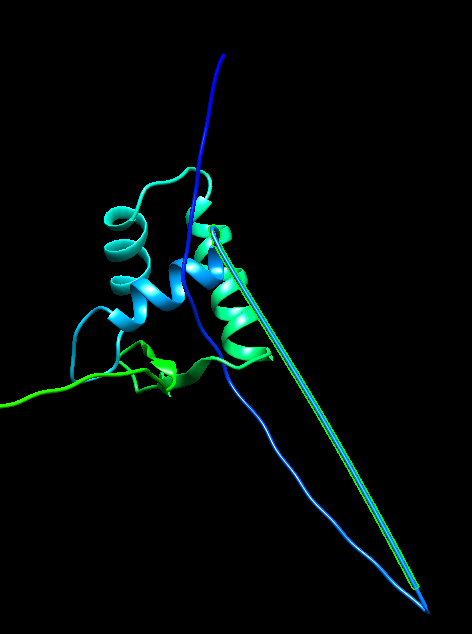

In ini file there is a clear problem - a knot

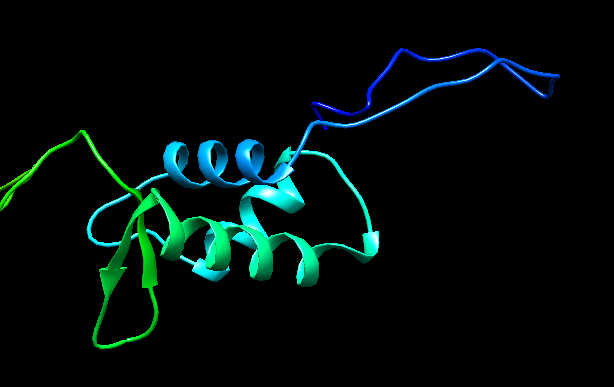

Looks the problem was partially recovered during optimization.

In [84]:
mod_f_name_0=a.outputs[0]['name']
mod_f_name_0

'humanH1.B99990001.pdb'

In [85]:
import nglview as nv
nv.show_structure_file(mod_f_name_0)

NGLWidget()

In [86]:
#Let's do some evaluations
from modeller import *
from modeller.scripts import complete_pdb

log.verbose()    # request verbose output
env = environ()
env.libs.topology.read(file='$(LIB)/top_heav.lib') # read topology
env.libs.parameters.read(file='$(LIB)/par.lib') # read parameters

# read model file
mdl = complete_pdb(env, mod_f_name_0)

# Assess with DOPE:
s = selection(mdl)   # all atom selection
s.assess_dope(output='ENERGY_PROFILE NO_REPORT', file='model.profile',
              normalize_profile=True, smoothing_window=15)

# read model file
mdl = complete_pdb(env, '1HST.pdb')

# Assess with DOPE:
s = selection(mdl)   # all atom selection
s.assess_dope(output='ENERGY_PROFILE NO_REPORT', file='1HST_A.profile',
              normalize_profile=True, smoothing_window=15)

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     20931908   20441.316    19.962

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     20932436   20441.832    19.963
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     20981036   20489.293    20.009
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     20994336   20502.281    20.022
openf___224_> Open           $

-14587.330078125

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     20851590   20362.881    19.886

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     20852118   20363.396    19.886
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     20900718   20410.857    19.932
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     20914018   20423.846    19.945
openf___224_> Open           $

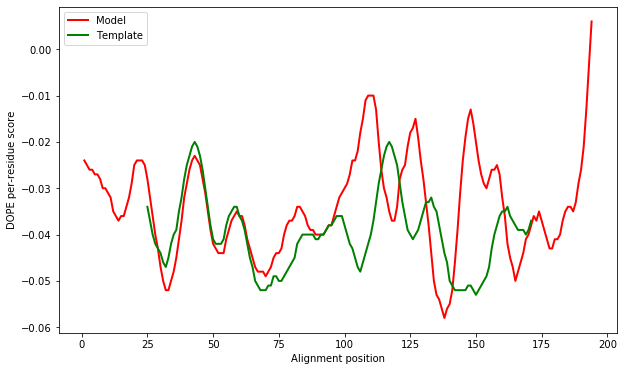

In [87]:
%matplotlib inline
import pylab
import modeller

def r_enumerate(seq):
    """Enumerate a sequence in reverse order"""
    # Note that we don't use reversed() since Python 2.3 doesn't have it
    num = len(seq) - 1
    while num >= 0:
        yield num, seq[num]
        num -= 1

def get_profile(profile_file, seq):
    """Read `profile_file` into a Python array, and add gaps corresponding to
       the alignment sequence `seq`."""
    # Read all non-comment and non-blank lines from the file:
    f = open(profile_file)
    vals = []
    for line in f:
        if not line.startswith('#') and len(line) > 10:
            spl = line.split()
            vals.append(float(spl[-1]))
    # Insert gaps into the profile corresponding to those in seq:
    for n, res in r_enumerate(seq.residues):
        for gap in range(res.get_leading_gaps()):
            vals.insert(n, None)
    # Add a gap at position '0', so that we effectively count from 1:
    vals.insert(0, None)
    return vals

e = modeller.environ()
a = modeller.alignment(e, file='humanH1-1HST_A.ali')

template = get_profile('1HST_A.profile', a['1HST_A'])
model = get_profile('model.profile', a['humanH1'])

# Plot the template and model profiles in the same plot for comparison:
pylab.figure(1, figsize=(10,6))
pylab.xlabel('Alignment position')
pylab.ylabel('DOPE per-residue score')
pylab.plot(model, color='red', linewidth=2, label='Model')
pylab.plot(template, color='green', linewidth=2, label='Template')
pylab.legend()
pylab.show()
# pylab.savefig('dope_profile.png', dpi=65)


## Example 2: Building models from several templates

## Example 3: Loop modeling and refinement

We will use again H1 histone.
When we do automodel without selection the structure is rebuilt, so conformations of side chains change. So we need to do some selection.
The loop modeling routine that does not use template-dependent restraints, does a much more thorough optimization.
Loopmodel is automodel + additional loop refinment!
What we want to do is to append the tails to H1 histone without touching its structure.
See also:
https://salilab.org/modeller/wiki/Missing%20residues


In [107]:
#Let's get the full sequence of chicken H1 in PDB
from Bio import SeqIO
import urllib.request

handle = urllib.request.urlopen("http://www.uniprot.org/uniprot/P02259.xml")

record = SeqIO.read(handle, "uniprot-xml")
#print(record)
print(record.name)
print(record.seq)

H5_CHICK
MTESLVLSPAPAKPKRVKASRRSASHPTYSEMIAAAIRAEKSRGGSSRQSIQKYIKSHYKVGHNADLQIKLSIRRLLAAGVLKQTKGVGASGSFRLAKSDKAKRSPGKKKKAVRRSTSPKKAARPRKARSPAKKPKATARKARKKSRASPKKAKKPKTVKAKSRKASKAKKVKRSKPRAKSGARKSPKKK


In [108]:
record.name='sequence:gallusH1::::::::'
record.description=''
record.id='gallusH1'
handle = open('gallusH1.ali', "w")
writer = SeqIO.PirIO.PirWriter(handle)
writer.write_file([record])
handle.close()
!cat gallusH1.ali

>P1;gallusH1
sequence:gallusH1::::::::
MTESLVLSPAPAKPKRVKASRRSASHPTYSEMIAAAIRAEKSRGGSSRQSIQKYIKSHYK
VGHNADLQIKLSIRRLLAAGVLKQTKGVGASGSFRLAKSDKAKRSPGKKKKAVRRSTSPK
KAARPRKARSPAKKPKATARKARKKSRASPKKAKKPKTVKAKSRKASKAKKVKRSKPRAK
SGARKSPKKK*


In [112]:
#Now we'll do alignment using Modeller
from modeller import *

env = environ()
aln = alignment(env)
mdl = model(env, file='1HST', model_segment=('FIRST:A','LAST:A'))
aln.append_model(mdl, align_codes='1HST_A', atom_files='1HST.pdb')
aln.append(file='gallusH1.ali', align_codes='gallusH1')
aln.align2d()
aln.write(file='gallusH1-1HST_A.ali', alignment_format='PIR')
!cat gallusH1-1HST_A.ali

openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     38599376   37694.703    36.811

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     38599904   37695.219    36.812
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     38648504   37742.680    36.858
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     38661804   37755.668    36.871
openf___224_> Open           $

In [113]:
# Loop refinement of an existing model
from modeller import *
from modeller.automodel import *

log.verbose()
env = environ()

# directories for input atom files
env.io.atom_files_directory = './:../atom_files'


# Read in HETATM records from template PDBs 
env.io.hetatm = True

# Read in water molecules from template PDBs 
env.io.water = True

# Create a new class based on 'loopmodel' so that we can redefine
# What part to model
# IMPORTANT:
# 1. All missing structure will be at least generated in some way. Whether is will be refined depends on selections.
# 2. Selections refer to numbers in alignment!
# 3. select_atoms - selects atoms for automodel protocol 
# 3. select_loop_atoms - selects atoms for additional loop refinmend with MD.

class MyLoop(loopmodel):
    def select_atoms(self):
        return selection(self.residue_range('1', '24'),self.residue_range('99', '190'))
    def select_loop_atoms(self):
        return selection(self.residue_range('1', '24'),self.residue_range('99', '190'))


m = MyLoop(env,alnfile='gallusH1-1HST_A.ali',knowns='1HST_A',
           sequence='gallusH1')          # code of the target

m.loop.starting_model= 1           # index of the first loop model 
m.loop.ending_model  = 1          # index of the last loop model
m.loop.md_level = refine.very_fast # loop refinement method; this yields
                                   # models quickly but of low quality;
                                   # use refine.slow for better models

m.make()


openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     37999602   37108.984    36.239

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     38000130   37109.500    36.240
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     38048730   37156.961    36.286
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     38062030   37169.953    36.299
openf___224_> Open           $

In [114]:
mod_f_name_0=m.outputs[0]['name']
mod_f_name_0

'gallusH1.B99990001.pdb'

In [115]:
import nglview as nv
nv.show_structure_file(mod_f_name_0)

NGLWidget()

One can check in Chimera that the globular domain structure is identical to the original one.

# Example 4. Working with multiple chains
- see https://salilab.org/modeller/manual/node29.html
- see also https://salilab.org/modeller/manual/node30.html
- In this example we will add missing tails to nucleosome 1AOI structure.

In [134]:
# Let's get template structure
import pypdb
import nglview as nv

with open('1AOI.pdb','w') as f:
    f.write(pypdb.get_pdb_file('1AOI', filetype='pdb', compression=False))
nv.show_structure_file('1AOI.pdb')

NGLWidget()

In [135]:
#Let's get the template sequences that are really present as 3D coordinates in PDB
# This approach currently only gets the protein part
from Bio.PDB import *
#See docs here https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ
p = PDBParser()
structure = p.get_structure('1AOI', '1AOI.pdb')
ppb = PPBuilder()
pdb_seqs={}
for pp,ch in zip(ppb.build_peptides(structure),'ABCDEFGH'):
    pdb_seqs[ch]=pp.get_sequence()
pdb_seqs

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 12971.
  PDBConstructionWarning)
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 12974.
  PDBConstructionWarning)
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 12977.
  PDBConstructionWarning)
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 12981.
  PDBConstructionWarning)
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12986.
  PDBConstructionWarning)
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/PDB/S

{'A': Seq('PHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMA...ERA', ProteinAlphabet()),
 'B': Seq('KVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYT...FGG', ProteinAlphabet()),
 'C': Seq('GKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEY...LPK', ProteinAlphabet()),
 'D': Seq('KKRRKTRKESYAIYVYKVLKQVHPDTGISSKAMSIMNSFVNDVFERIAGEASRL...SAK', ProteinAlphabet()),
 'E': Seq('LATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVRE...ERA', ProteinAlphabet()),
 'F': Seq('KRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDA...FGG', ProteinAlphabet()),
 'G': Seq('AKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLTAEILEL...PKK', ProteinAlphabet()),
 'H': Seq('KKRRKTRKESYAIYVYKVLKQVHPDTGISSKAMSIMNSFVNDVFERIAGEASRL...SAK', ProteinAlphabet())}

In [188]:
#Let's get SEQREC sequences
#Another way if from fasta files provided by PDB
# We get SEQRECORDS  NOTE - these are provided by authors
# and usually contain parts unresolved in 3D
from Bio import SeqIO
import urllib.request
!curl 'https://www.rcsb.org/pdb/download/downloadFastaFiles.do?structureIdList=1AOI&compressionType=uncompressed'> temp.fasta
records = SeqIO.parse('temp.fasta', "fasta")
chseq_seqrec={}
for r in records:
    chseq_seqrec.update({r.id.split('|')[0].split(':')[1]:r.seq})
chseq_seqrec


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1438    0  1438    0     0   2264      0 --:--:-- --:--:-- --:--:--  2261


{'A': Seq('LATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVRE...ERA', SingleLetterAlphabet()),
 'B': Seq('KRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDA...FGG', SingleLetterAlphabet()),
 'C': Seq('GKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEY...PKK', SingleLetterAlphabet()),
 'D': Seq('KKRRKTRKESYAIYVYKVLKQVHPDTGISSKAMSIMNSFVNDVFERIAGEASRL...SAK', SingleLetterAlphabet()),
 'E': Seq('LATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVRE...ERA', SingleLetterAlphabet()),
 'F': Seq('KRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDA...FGG', SingleLetterAlphabet()),
 'G': Seq('GKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEY...PKK', SingleLetterAlphabet()),
 'H': Seq('KKRRKTRKESYAIYVYKVLKQVHPDTGISSKAMSIMNSFVNDVFERIAGEASRL...SAK', SingleLetterAlphabet()),
 'I': Seq('ATCAATATCCACCTGCAGATTCTACCAAAAGTGTATTTGGAAACTGCTCCATCA...GAT', SingleLetterAlphabet()),
 'J': Seq('ATCAATATCCACCTGCAGATTCTACCAAAAGTGTATTTGGAAACTGCTCCATCA...GAT', SingleLetterAlphabet())}

In [189]:
for k in chseq_seqrec:
    print(k,len(chseq_seqrec[k]))

A 116
B 87
C 116
D 99
E 116
F 87
G 116
H 99
I 146
J 146


### NOTE: actually, this SEQREC is not the full sequence of proteins, as seen if compared to UNIPROT, however, UNIPROT will give sequences with some point mutations also. The best option is to take the sequences manually from paper. Here for the sake of an example we will use the SEQRECs.

### We need to specify the sequnces to model

In [190]:
modseqs=chseq_seqrec

### What we now need is to get an alignment of special kind where chains would be separated by /. We also need that gaps would be only on tails. This is not actually trivial. We will use here the simple Biopython aligner with tunes options to do it.

In [191]:
from Bio import pairwise2
pdb_seqs['I']=chseq_seqrec['I']
pdb_seqs['J']=chseq_seqrec['J']

pdb_seqs_aln={}
for i in 'ABCDEFGHIJ':
    alignments = pairwise2.align.globalxs(modseqs[i], pdb_seqs[i],-10,-1,penalize_end_gaps=False)
    print(alignments[0][1])
    pdb_seqs_aln[i]=alignments[0][1]

------------------PHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVALFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA
----KVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG
GKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAVRNDEELNKLLGRVTIAQGGVLPNIQSVLLPK-
KKRRKTRKESYAIYVYKVLKQVHPDTGISSKAMSIMNSFVNDVFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVTKYTSAK
LATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVALFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA
KRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG
--------AKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAVRNDEELNKLLGRVTIAQGGVLPNIQSVLLPKK
KKRRKTRKESYAIYVYKVLKQVHPDTGISSKAMSIMNSFVNDVFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVTKYTSAK
ATCAATATCCACCTGCAGATTCTACCAAAAGTGTATTTGGAAACTGCTCCATCAAAAGGCATGTTCAGCTGAATTCAGCTGAACATGCCTTTTGATGGAGCAGTTTCCAAATACACTTTTGGTAGAATCTGCAGGTGGATATTGAT
ATCAATATC

In [192]:
#Let's make and write PIR record for sequnces to model.
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC

#We will need to rename DNA as a ligand .
modseqs['I']='.'*len(modseqs['I'])
modseqs['J']='.'*len(modseqs['J'])



seq_mod='/'.join([str(modseqs[i]) for i in 'IJABCDEFGH'])


record = SeqRecord(Seq(seq_mod,IUPAC.protein),id="nuc", name="sequence:nuc::::::::",description="")

handle = open('nuc.ali', "w")
writer = SeqIO.PirIO.PirWriter(handle)
writer.write_file([record])
handle.close()
!cat nuc.ali

>P1;nuc
sequence:nuc::::::::
............................................................
............................................................
........................../.................................
............................................................
...................................................../LATKAA
RKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQ
SSAVMALQEASEAYLVALFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA/KRHRKVLRD
NIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAM
DVVYALKRQGRTLYGFGG/GKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVG
AGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAVRNDEELNKLLGRVTIAQ
GGVLPNIQSVLLPKK/KKRRKTRKESYAIYVYKVLKQVHPDTGISSKAMSIMNSFVNDVF
ERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVTKYTSAK/LATK
AARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLR
FQSSAVMALQEASEAYLVALFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA/KRHRKVL
RDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVT
AMDVVYALKRQGRTLYGFGG/GKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGN

In [193]:
#Now we'll need to make ali-files
from modeller import *
# env.io.hetatm=True 
io_data.hetatm=True
env = environ()
aln = alignment(env)
mdl = model(env, file='1AOI', model_segment=('FIRST:I','LAST:H'))
aln.append_model(mdl, align_codes='1AOI', atom_files='1AOI.pdb')
aln.append(file='nuc.ali', align_codes='nuc')
aln.write(file='nuc-1AOI_mod.ali', alignment_format='PIR')
!cat nuc-1AOI_mod.ali



openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     39726319   38795.234    37.886

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     39726847   38795.750    37.886
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     39775447   38843.211    37.933
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:     39788747   38856.199    37.946
openf___224_> Open           $

In [194]:
#Now we will make a hack, we will read the MODELLER generated alignment with all metadata and substitute the alignment there
r=[]
with open("nuc-1AOI_mod.ali") as handle:
    for record in SeqIO.PirIO.PirIterator(handle):
#         record.name=''
        r.append(record)
# record.name='sequence:gallusH1::::::::'
# record.description=''
# record.id='gallusH1'
pdb_seqs_aln['I']='.'*len(pdb_seqs_aln['I'])
pdb_seqs_aln['J']='.'*len(pdb_seqs_aln['J'])

seq_pdb='/'.join([str(pdb_seqs_aln[i]) for i in 'IJABCDEFGH'])
r[0].seq=Seq(seq_pdb,IUPAC.protein)
r[1].seq=Seq(seq_mod,IUPAC.protein)
handle = open('nuc-1AOI.ali', "w")
writer = SeqIO.PirIO.PirWriter(handle)
writer.write_file(r)
handle.close()
!cat nuc-1AOI.ali


>P1;1AOI
1AOI - structureX:1AOI.pdb:  1 :I:+1097:H:MOL_ID 1; MOLECULE PALINDROMIC 146 BP DNA REPEAT 8/9 FROM HUMAN X- CHROMOSOME ALPHA SATELLITE DNA; CHAIN I, J; ENGINEERED YES; MOL_ID 2; MOLECULE HISTONE H3; CHAIN A, E; FRAGMENT HISTONE H3; ENGINEERED YES; MOL_ID 3; MOLECULE HISTONE H4; CHAIN B, F; FRAGMENT HISTONE H4; ENGINEERED YES; MOL_ID 4; MOLECULE HISTONE H2A; CHAIN C, G; FRAGMENT HISTONE H2A; ENGINEERED YES; MOL_ID 5; MOLECULE HISTONE H2B; CHAIN D, H; FRAGMENT HISTONE H2B; ENGINEERED YES; MUTATION YES:MOL_ID 1; SYNTHETIC YES; MOL_ID 2; ORGANISM_SCIENTIFIC XENOPUS LAEVIS; ORGANISM_COMMON AFRICAN CLAWED FROG; ORGANISM_TAXID 8355; EXPRESSION_SYSTEM ESCHERICHIA COLI; EXPRESSION_SYSTEM_TAXID 562; MOL_ID 3; ORGANISM_SCIENTIFIC XENOPUS LAEVIS; ORGANISM_COMMON AFRICAN CLAWED FROG; ORGANISM_TAXID 8355; EXPRESSION_SYSTEM ESCHERICHIA COLI; EXPRESSION_SYSTEM_TAXID 562; OTHER_DETAILS SYNTHETIC GENE, OPTIMIZED CODON USAGE FOR ESCHERICHIA COLI; MOL_ID 4; ORGANISM_SCIENTIFIC XENOPUS LAEVIS; OR

### As in example 2 we will do loop modeling of the tails.
- We'll just need to add automatic tail identification.

In [229]:
import re
a=re.compile('\-+')
for i in a.finditer('aaa----aa--'):
    print(i.span())


(3, 7)
(9, 11)


In [237]:
from modeller import *
from modeller.automodel import *
import re
log.verbose()
env = environ()

# directories for input atom files
env.io.atom_files_directory = './:../atom_files'


# Read in HETATM records from template PDBs 
env.io.hetatm = False

# Read in water molecules from template PDBs 
env.io.water = False

# Create a new class based on 'loopmodel' so that we can redefine
# What part to model
# IMPORTANT:
# 1. All missing structure will be at least generated in some way. Whether is will be refined depends on selections.
# 2. Selections refer to numbers in alignment!
# 3. select_atoms - selects atoms for automodel protocol 
# 3. select_loop_atoms - selects atoms for additional loop refinmend with MD.

## For numbering resiudes see https://salilab.org/modeller/manual/node23.html
# Please note that the residue numbers and chain IDs refer to the built model, not to the template(s). This is because template PDB residue numbering can be inconsistent, and in the case where you have two or more templates, residues from different parts of the sequence coming from different templates could have the same number. MODELLER always names the model residues consistently, counting up from 1. No chain ID is assigned when building a single chain model, but if you build a multi-chain model, chain IDs A, B, C, etc are assigned2.2. If in doubt about residue numbering, first build a model using the simple script in section 2.1, and then look at the final model (or the initial unoptimized .ini model) for the residue numbering.

class MyLoop(loopmodel):
    def special_patches(self, aln): # see https://salilab.org/modeller/manual/node30.html
        # Rename both chains and renumber the residues in each
        self.rename_segments(segment_ids=['I','J','A','B','C','D','E','F','G','H'],
                             renumber_residues=[-72, -73,1,1,1,1,1,1,1,1,1])
    def set_sel(self):
        self.sel=[]
        a=re.compile('\-+')
        for i in a.finditer(seq_pdb.replace('/','')): # ACCOUNT FOR / !!!!!
            self.sel.append((i.span()[0],i.span()[1]-1)) #NEED TO CHECK IF 0-based numbering works, or we need to use PDB numbering with quotes???? 
    def sel_man(self):
        s=selection()
        self.set_sel()
        for i in self.sel:
            s.add(self.residue_range(i[0],i[1]))
        return s
    def select_atoms(self):
        return self.sel_man()
    def select_loop_atoms(self):
        return self.sel_man()

m = MyLoop(env,alnfile='nuc-1AOI.ali',knowns='1AOI',
           sequence='nuc')          # code of the target

m.loop.starting_model= 1           # index of the first loop model 
m.loop.ending_model  = 1          # index of the last loop model
m.loop.md_level = refine.very_fast # loop refinement method; this yields
                                   # models quickly but of low quality;
                                   # use refine.slow for better models
# m.starting_model = 1
# m.ending_model = 5

m.make()


openf___224_> Open           $(LIB)/restyp.lib
openf___224_> Open           ${MODINSTALL9v21}/modlib/resgrp.lib
rdresgr_266_> Number of residue groups:        2
openf___224_> Open           ${MODINSTALL9v21}/modlib/sstruc.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:    474302561  463186.094   452.330

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:    474303089  463186.625   452.331
openf___224_> Open           ${MODINSTALL9v21}/modlib/resdih.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:    474351689  463234.062   452.377
rdrdih__263_> Number of dihedral angle types         :        9
              Maximal number of dihedral angle optima:        3
              Dihedral angle names                   :  Alph Phi Psi Omeg chi1 chi2 chi3 chi4 chi5
openf___224_> Open           ${MODINSTALL9v21}/modlib/radii.lib

Dynamically allocated memory at   amaxlibraries [B,KiB,MiB]:    474364989  463247.062   452.390
openf___224_> Open           $

In [238]:
mod_f_name_0=m.outputs[0]['name']
mod_f_name_0
#PS there is also a loop model file nuc.BL ... - you may need to use it!!!

'nuc.B99990001.pdb'

In [239]:
import nglview as nv
nv.show_structure_file(mod_f_name_0)

NGLWidget()

# Suppl. A. Various ways to obtain (full) sequences of chains in PDB

## Get protein sequences directly from PDB files by reading the structure via BioPython
NOTE: does not support DNA

In [121]:
#Let's get the template sequences that are really present as 3D coordinates in PDB
# This approach currently only gets the protein part
from Bio.PDB import *
#See docs here https://biopython.org/wiki/The_Biopython_Structural_Bioinformatics_FAQ
p = PDBParser()
structure = p.get_structure('1AOI', '1AOI.pdb')
ppb = PPBuilder()
pdb_seqs=[]
for pp in ppb.build_peptides(structure):
    pdb_seqs.append(pp.get_sequence())
    print(pp.get_sequence())

PHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVALFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA
KVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG
GKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAVRNDEELNKLLGRVTIAQGGVLPNIQSVLLPK
KKRRKTRKESYAIYVYKVLKQVHPDTGISSKAMSIMNSFVNDVFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVTKYTSAK
LATKAARKSAPATGGVKKPHRYRPGTVALREIRRYQKSTELLIRKLPFQRLVREIAQDFKTDLRFQSSAVMALQEASEAYLVALFEDTNLCAIHAKRVTIMPKDIQLARRIRGERA
KRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQGRTLYGFGG
AKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAVRNDEELNKLLGRVTIAQGGVLPNIQSVLLPKK
KKRRKTRKESYAIYVYKVLKQVHPDTGISSKAMSIMNSFVNDVFERIAGEASRLAHYNKRSTITSREIQTAVRLLLPGELAKHAVSEGTKAVTKYTSAK


/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 12971.
  PDBConstructionWarning)
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 12974.
  PDBConstructionWarning)
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain I is discontinuous at line 12977.
  PDBConstructionWarning)
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain J is discontinuous at line 12981.
  PDBConstructionWarning)
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 12986.
  PDBConstructionWarning)
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/Bio/PDB/S

## Get SEQREC records from PDB

In [122]:
#Let's get SEQREC sequences
#Another way if from fasta files provided by PDB
# We get SEQRECORDS  NOTE - these are provided by authors
# and usually contain parts unresolved in 3D
from Bio import SeqIO
import urllib.request
!curl 'https://www.rcsb.org/pdb/download/downloadFastaFiles.do?structureIdList=1KX5&compressionType=uncompressed'> temp.fasta
records = SeqIO.parse('temp.fasta', "fasta")
chseq_seqrec={}
for r in records:
    chseq_seqrec.update({r.id.split('|')[0].split(':')[1]:r.seq})
chseq_seqrec

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1584    0  1584    0     0   2448      0 --:--:-- --:--:-- --:--:--  2448


{'A': Seq('ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRY...ERA', SingleLetterAlphabet()),
 'B': Seq('SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEET...FGG', SingleLetterAlphabet()),
 'C': Seq('SGRGKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAV...KSK', SingleLetterAlphabet()),
 'D': Seq('PEPAKSAPAPKKGSKKAVTKTQKKDGKKRRKTRKESYAIYVYKVLKQVHPDTGI...SAK', SingleLetterAlphabet()),
 'E': Seq('ARTKQTARKSTGGKAPRKQLATKAARKSAPATGGVKKPHRYRPGTVALREIRRY...ERA', SingleLetterAlphabet()),
 'F': Seq('SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEET...FGG', SingleLetterAlphabet()),
 'G': Seq('SGRGKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAV...KSK', SingleLetterAlphabet()),
 'H': Seq('PEPAKSAPAPKKGSKKAVTKTQKKDGKKRRKTRKESYAIYVYKVLKQVHPDTGI...SAK', SingleLetterAlphabet()),
 'I': Seq('ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTGCTCCATCA...GAT', SingleLetterAlphabet()),
 'J': Seq('ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTGCTCCATCA...GAT', SingleLetterAlphabet())}

## Obtain from UNIPROT
### NOTE: actually the sequence may differ, it is just a best blast(?) hit match made by PDB.

In [240]:
#Let's get chain to uniprot accessions mapping
import pypdb
# pypdb.describe_pdb('1AOI')
info=pypdb.to_dict(pypdb.get_info('1AOI'))
polinfo=info['molDescription']['structureId']['polymer']
print(polinfo)
if not isinstance(polinfo, list):
    polinfo=[polinfo]
chmap={}
for i in polinfo:
    for k in i['chain'] if isinstance(i['chain'],list) else [i['chain']]:
        chmap.update({k['@id']:i.get('macroMolecule',{'accession':{'@id':None}})['accession']['@id']})
chmap

[{'@entityNr': '1', '@length': '146', '@type': 'dna', '@weight': '45053.9', 'chain': [{'@id': 'I'}, {'@id': 'J'}], 'polymerDescription': {'@description': 'PALINDROMIC 146 BP DNA REPEAT 8/9 FROM HUMAN X-CHROMOSOME ALPHA SATELLITE DNA'}}, {'@entityNr': '2', '@length': '116', '@type': 'protein', '@weight': '13244.5', 'chain': [{'@id': 'A'}, {'@id': 'E'}], 'Taxonomy': {'@name': 'Xenopus laevis', '@id': '8355'}, 'macroMolecule': {'@name': 'Histone H3.3C', 'accession': {'@id': 'P02302'}}, 'polymerDescription': {'@description': 'HISTONE H3'}, 'fragment': {'@desc': 'HISTONE H3'}, 'mutation': {'@desc': 'V21A, K26R, C28S, R86S'}}, {'@entityNr': '3', '@length': '87', '@type': 'protein', '@weight': '9990.77', 'chain': [{'@id': 'B'}, {'@id': 'F'}], 'Taxonomy': {'@name': 'Xenopus laevis', '@id': '8355'}, 'macroMolecule': {'@name': 'Histone H4', 'accession': {'@id': 'P62799'}}, 'polymerDescription': {'@description': 'HISTONE H4'}, 'fragment': {'@desc': 'HISTONE H4'}}, {'@entityNr': '4', '@length': '1

{'I': None,
 'J': None,
 'A': 'P02302',
 'E': 'P02302',
 'B': 'P62799',
 'F': 'P62799',
 'C': 'P06897',
 'G': 'P06897',
 'D': 'P02281',
 'H': 'P02281'}

In [124]:
#Let's get full UNIPROT sequences and strip methionine
from Bio import SeqIO
import urllib.request
chseq_uniprot={}
for k,v in chmap.items():
    if v is None:
        continue
    handle = urllib.request.urlopen("http://www.uniprot.org/uniprot/%s.xml"%v)
    record = SeqIO.read(handle, "uniprot-xml")
    #print(record)
#     print(record.name)
#     print(record.seq)
    chseq_uniprot[k]=record.seq[1:]
chseq_uniprot

{'A': Seq('ARTKQTARKSTGGKAPRKQLVTKAAKKCAPATGGVKKPHRYRPGTVALREIRRY...ERA', ProteinAlphabet()),
 'E': Seq('ARTKQTARKSTGGKAPRKQLVTKAAKKCAPATGGVKKPHRYRPGTVALREIRRY...ERA', ProteinAlphabet()),
 'B': Seq('SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEET...FGG', ProteinAlphabet()),
 'F': Seq('SGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEET...FGG', ProteinAlphabet()),
 'C': Seq('SGRGKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAV...KSK', ProteinAlphabet()),
 'G': Seq('SGRGKQGGKTRAKAKTRSSRAGLQFPVGRVHRLLRKGNYAERVGAGAPVYLAAV...KSK', ProteinAlphabet()),
 'D': Seq('PEPAKSAPAPKKGSKKAVTKTQKKDGKKRRKSRKESYAIYVYKVLKQVHPDTGI...SAK', ProteinAlphabet()),
 'H': Seq('PEPAKSAPAPKKGSKKAVTKTQKKDGKKRRKSRKESYAIYVYKVLKQVHPDTGI...SAK', ProteinAlphabet())}

### NB this is a good example when UNIPROT and SEQREC differ in several amino acids - always check!